this worksheets is part of the [mlvu machine learning course](https://mlvu.github.io)<br>
setting up your environment: https://bit.ly/3bzpn5C

# Worksheet 2: SciKit-learn

SciKit is a large collection of python libraries for scientific computing. SciKit-learn, or sklearn is its Machine Learning library. It's very complete, and integrates well with other data science tools like Numpy, Matplotlib, Pandas and Keras.

We'll start by importing it, together with numpy and matplotlib


In [2]:
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
%matplotlib inline

## Classification

We'll start with a classification problem, based on the data we used in the previous worksheet. This time we've removed the living cricketers, and extended the data with a third column, indicating whether the cricketer was "killed in action" (i.e. they died in a war). 

Let's start by loading the data and having a look at it. Note that we are using the third column in the data for color. (the option ``cmap='RdYlBu_r`` just makes the scatter function use the right colors)

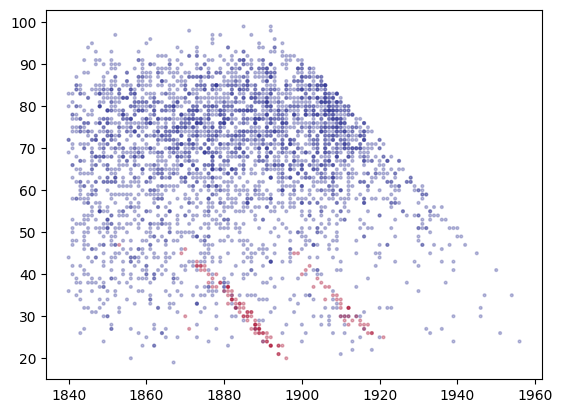

In [3]:
data = np.loadtxt('cricketers.cls.csv', delimiter=',')
plt.scatter(data[:,0], data[:,1], s=4, alpha=0.3, c=data[:,2], cmap='RdYlBu_r');

This will be our classification task: given the age of death and year of birth of a cricketer, predict whether they died in a war. Before we start, it's worth noting the following:
* Our data has high class-imbalance. The proportion of cricketers killed in action is very low.
* The target value has a natural relation to one of the features: if people died young, they're more likely to have been killed in action. 
*  The relationship with the other variable is also strong, but slightly arbitrary: we know that the years 1914-18 and 1939-1945 are special, but this is background knowlegde that a succesful classifier will have to memorize.

First, we'll split our data into the features ``x`` and the target ``y``.

In [5]:
x = data[:,0:2]
y = data[:,2]

Next, we'll need to split the data into the training data (which we'll show to the learner) and the test data (which we'll hold back to see how well it has done). Sklearn provides a utility function for this.

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

Now we can apply an _estimator_ to the data. An estimator is anything that implements the method ``fit(x, y)`` which takes data and learns from it, and the method ``predict(T)`` which takes a new instance and predicts the target value.

We'll start with a simple linear classifier. For reasons that will become clear later in the course, we do this by using the "SVC model" with a "linear kernel."

In [7]:
from sklearn.svm import SVC

linear = SVC(kernel='linear')
linear.fit(x_train, y_train)

SVC(kernel='linear')

Our model has now been fit to the training data. Let's make up some new cricketers, and see how it classifies them.

In [8]:
nw_data = np.asarray([[1896, 20],[1922, 20]])
linear.predict(nw_data)

array([0., 0.])

Our classifier thinks both of them are non-KIA (even though they both died in the middle of a World War). Does this mean our classifier has poor accuracy? Let's [compute it](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) and see.

In [9]:
from sklearn.metrics import accuracy_score

y_predicted = linear.predict(x_test)
accuracy_score(y_test, y_predicted)

0.9669421487603306

It gets 96% of the test correct. That doesn't seem so bad.

Since we have a 2D feature space, we can visualize exactly what the classifier thinks. We simply color each point by what class the classifier assigns. The library ``mlxtend`` provides a utility function for this. We'll also plot the first 500 examples from the test set.

This is a slow function, so you may have to wait a while for it to finish.

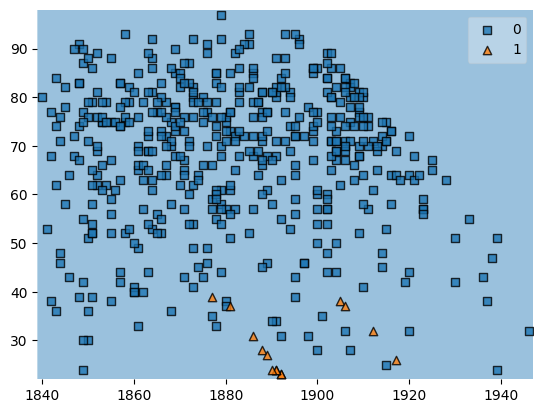

In [11]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(x_test[:500], y_test.astype(np.int32)[:500], clf=linear);

#You may get a warning about contour levels. Don't worry about that. Retry the cell if something goes wrong.

The colors and shapes of the points indicate the true classes, the background color(s) indicate the predictions of the classifier.

Clearly, the linear classifier just classifies everything as non-KIA. Due to the class imbalance, this still yields a high accuracy. Let's try another classifier, and see if it is flexible enough to isolate the small regions of feature space that correspond to the two world wars.

We'll use a **decision tree** this time.

In [12]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)

y_predicted = tree.predict(x_test)
accuracy_score(y_test, y_predicted)

0.9775678866587958

A little bit higher. Not a lot, but then, there wasn't a lot higher to go. Let's visualize the classifications.

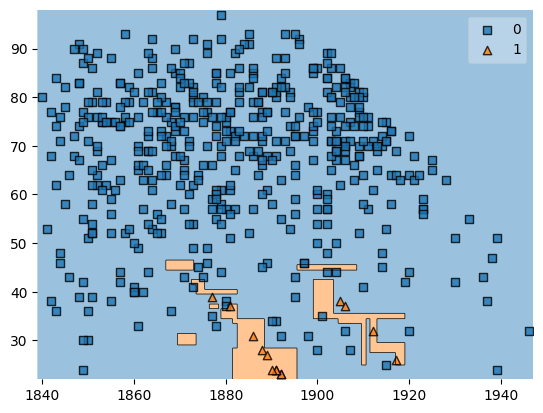

In [13]:
plot_decision_regions(x_test[:500], y_test.astype(np.int32)[:500], clf=tree);

It carves out some regions for the KIA class, but they're not very natural. Let's try one more classifier: k-Nearest Neighbors.

accuracy  0.9775678866587958


/tmp/ipykernel_24889/4054963184.py:9: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(x_test[:500], y_test.astype(np.integer)[:500], clf=knn);


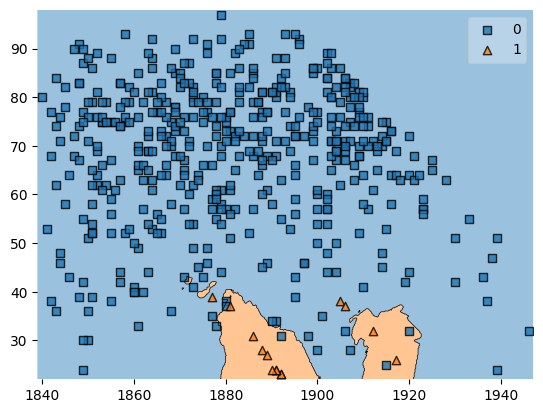

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(15) # We set the number of neighbors to 15
knn.fit(x_train, y_train)

y_predicted = knn.predict(x_test)
print('accuracy ', accuracy_score(y_test, y_predicted))

plot_decision_regions(x_test[:500], y_test.astype(np.integer)[:500], clf=knn); 

### ROC Curves

Clearly, the accuracy is not a very informative value with such a high class-imbalance. Instead, we can plot the ROC curve: we retrieve class probabilities form the models, and vary the decision threshold. We plot the number of false positives against the number of false negatives (see lecture 3 for more information).

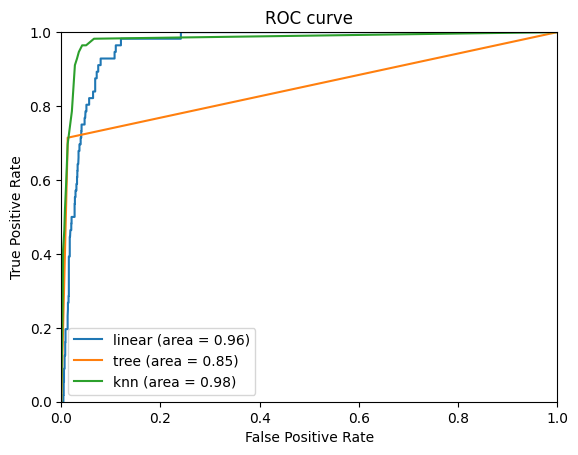

In [16]:
from sklearn.metrics import roc_curve, auc

# The linear classifier doesn't produce class probabilities by default. We'll retrain it for probabilities.
linear = SVC(kernel='linear', probability=True)
linear.fit(x_train, y_train)

# We'll need class probabilities from each of the classifiers
y_linear = linear.predict_proba(x_test)
y_tree  = tree.predict_proba(x_test)
y_knn   = knn.predict_proba(x_test)

# Compute the points on the curve
# We pass the probability of the second class (KIA) as the y_score
curve_linear = sklearn.metrics.roc_curve(y_test, y_linear[:, 1])
curve_tree   = sklearn.metrics.roc_curve(y_test, y_tree[:, 1])
curve_knn    = sklearn.metrics.roc_curve(y_test, y_knn[:, 1])

# Compute Area Under the Curve
auc_linear = auc(curve_linear[0], curve_linear[1])
auc_tree   = auc(curve_tree[0], curve_tree[1])
auc_knn    = auc(curve_knn[0], curve_knn[1])

plt.plot(curve_linear[0], curve_linear[1], label='linear (area = %0.2f)' % auc_linear)
plt.plot(curve_tree[0], curve_tree[1], label='tree (area = %0.2f)' % auc_tree)
plt.plot(curve_knn[0], curve_knn[1], label='knn (area = %0.2f)'% auc_knn)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve');

plt.legend();

This paints an interesting picture. If we look at the raw probabilities, the linear classifier almost always assigns non-KIA a higher probability than KIA. However, if we decide that we will allow a few false positives (non-KIA  classified as KIA), we can increase the true positive rate a lot. 

The decision tree classifier suffers here, because it computes its class probabilities from very small numbers of examples. This makes the number of different probabilities it can return smaller, which in turn means that we have less power to trade false positives for true positives, by varying the decision threshold. You can probably improve its performance by tweaking its hyperparameters.

### Cross-validation

As we discussed in the lectures, cross-validation is a good way to make your estimates of accuracy more precise. However, it requires us to retrain the model many times on different splits of the data. This means that our training code looks a little different. 

We'll show briefly how it works for the linear model.

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

# The cross_val_score function does all the training for us. We simply pass 
# it the complete data, the model, and the metric.

linear = SVC(kernel='linear', probability=True)

# Train for 5 folds, returing ROC AUC. You can also try 'accuracy' as a scorer
scores = cross_val_score(linear, x, y, cv=5, scoring='roc_auc')

print('scores per fold ', scores)
print('  mean score    ', np.mean(scores))
print('  standard dev. ', np.std(scores))

scores per fold  [0.96065877 0.95349134 0.97131827 0.96656457 0.35981368]
  mean score     0.8423693261556089
  standard dev.  0.24135150079848233


Note that we are using cross validation on the whole dataset here. If we use cross validation for hyperparameter selection, we should still withhold a test set and test our final choice of hyperparameters on the test set.

## Regression

**NB: We're re-using some variable names below. This means that if you want to re-run the classification experiments above after running these cells, you should do "Kernel > Restart & Clear Output" and start again from the top. Make sure always to run at least the first cell, so the right packages are imported.**

Training regression models works very similar to training classification models. We'll try a quick example, to show the basics. Let's start with [one of the datasets that come pre-packaged with sklearn](https://scikit-learn.org/stable/datasets/toy_dataset.html). The data is described [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes). 

In [ ]:
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset, and select one feature (Body Mass Index)
x, y = datasets.load_diabetes(return_X_y=True)
x = x[:, 2].reshape(-1, 1)

# -- the reshape operation ensures that x still has two dimensions 
# (that is, we need it to be an n by 1 matrix, not a vector)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

plt.scatter(x_train[:, 0], y_train)

plt.xlabel('BMI')
plt.ylabel('disease progression');

Note that we have only one feature here. The feature space is the horizontal axis and the _output space_ is the vertical axis.

We'll assume that the basic idea is clear now, so we'll train three models in one go: linear regression, tree regression, and a knn regression. 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

linear = LinearRegression()
tree = DecisionTreeRegressor()
knn = KNeighborsRegressor(10)

linear.fit(x_train, y_train)
tree.fit(x_train, y_train)
knn.fit(x_train, y_train);

To plot them, we'll just compute their outputs for a series of linearly spaced input points. We'll also plot the training data.

In [ ]:
from sklearn.metrics import mean_squared_error

plt.scatter(x_train, y_train, alpha=0.1)

xlin = np.linspace(-0.10, 0.2, 500).reshape(-1, 1)
plt.plot(xlin, linear.predict(xlin), label='linear')
plt.plot(xlin, tree.predict(xlin), label='tree ')
plt.plot(xlin, knn.predict(xlin), label='knn ')

print('MSE linear ', mean_squared_error(y_test, linear.predict(x_test)))
print('MSE tree ', mean_squared_error(y_test, tree.predict(x_test)))
print('MSE knn', mean_squared_error(y_test, knn.predict(x_test)))

plt.legend();

Which model would you choose? 

### Hyperparameters

One thing we haven't looked at is _hyperparameters_. We've only used each model with its default settings. To show how crucial it is to check different hyperparameters, let's see how the number of neighbors influences the regression performance.

In [ ]:
plt.scatter(x_test, y_test, alpha=0.1)

xlin = np.linspace(-0.10, 0.2, 500).reshape(-1, 1)

knn05 = KNeighborsRegressor(5)
knn15 = KNeighborsRegressor(15)
knn50 = KNeighborsRegressor(50)

for model in [knn05, knn15, knn50]:
    model.fit(x_train, y_train)

plt.plot(xlin, knn05.predict(xlin), label='knn 5')
plt.plot(xlin, knn15.predict(xlin), label='knn 15')
plt.plot(xlin, knn50.predict(xlin), label='knn 50')

print('MSE knn  5 ', mean_squared_error(y_test, knn05.predict(x_test)))
print('MSE knn 15 ', mean_squared_error(y_test, knn15.predict(x_test)))
print('MSE knn 50 ', mean_squared_error(y_test, knn50.predict(x_test)))

plt.legend();

## Final comments

This should give you a basic starting point to start experimenting with sklearn. As before, there is much more to explore. Here are some tutorials that dig a little deeper:

* [The official quickstart guide](http://scikit-learn.org/stable/tutorial/basic/tutorial.html)
* [A DataCamp tutorial with interactive exercises](https://www.datacamp.com/community/tutorials/machine-learning-python)
* [Analyzing text data with SKLearn](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

SKLearn may seem a little bit more complex than libraries like numpy and matplotlib, but that's because it requires a little knowledge of the underlying machine learning models. Once you start to understand the models better, you'll undertand the library better as well.